In [1]:
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import matplotlib.pyplot as plt

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import imageio

#os.environ['FFMPEG_BINARY'] = 'ffmpeg'
#clear_output()

2023-07-05 20:01:56.319480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 20:01:56.474748: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-05 20:01:56.478397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-05 20:01:56.478413: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
from functions_general import *
from functions_data import *
from functions_update import *
from functions_visualization import *

In [3]:
%pwd

'/home/sanyam/Desktop/felixproject/Code'

## Load Model

In [4]:
CHANNEL_N = 4        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 1.0

CHEMISTRY_RATE=0.1
ENERGY_RATE=0.1
CA_SIZE=20

In [5]:
class Convolutional_Attention(tf.keras.layers.Layer):
    def __init__(self, h, d_k, d_v, d_model, flag_padding=True, input_dims=[BATCH_SIZE,TARGET_SIZE,TARGET_SIZE,4], **kwargs):
        super(Convolutional_Attention, self).__init__(**kwargs)
        self.input_dims=input_dims
        self.flag_padding = flag_padding
        self.attention = tf.keras.layers.Attention(use_scale=True)  # Scaled dot product attention 
        self.heads = h  # Number of attention heads to use
        self.d_k = d_k  # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v  # Dimensionality of the linearly projected values
        self.d_model = d_model
        self.W_q = tf.keras.layers.Dense(d_k)  # Learned projection matrix for the queries
        #self.W_k = tf.keras.layers.Dense(d_k)  # Learned projection matrix for the keys
        self.W_v = tf.keras.layers.Dense(d_v)  # Learned projection matrix for the values
        self.W_o = tf.keras.layers.Dense(d_model)  # Learned projection matrix for the multi-head output
    
    @tf.function
    def image_patches_layer(self,x,input_dims,mode='batch'):
        # extract patches. input [B,padded_h,padded_w,c], output [B,h,w,3*3*c]
        b, h, w, c=input_dims
        x = tf.image.extract_patches(x,
                                        sizes=[1, 3, 3, 1],
                                        strides=[1, 1, 1, 1],
                                        rates=[1, 1, 1, 1],
                                        padding='VALID')
        patch_dim=9*c
        if mode=='batch':
            # reshape to [Batch,h*w,9,c]
            x = tf.reshape(x,shape=[b,h*w,int(patch_dim/c),int(patch_dim/9)])
        elif mode=='patch':
            x = tf.reshape(x,shape=[b,h,w,int(patch_dim/(c*3)),int(patch_dim/(c*3)),int(patch_dim/9)])
        return x
    
    @tf.function
    def call(self, x):
        b, h, w, c=self.input_dims
        # apply circular padding to input
        if self.flag_padding:
            x = tf.numpy_function(wrap_pad, [x], tf.float32)
        # extract the patches from padded input
        x = self.image_patches_layer(x,self.input_dims)
        # Apply linear projections
        query = tf.reshape(self.W_q(x),shape=[b*h*w,9,c])
        value = tf.reshape(self.W_v(x),shape=[b*h*w,9,c])
        # key = tf.reshape(self.W_k(x),shape=[-1,9,c])
        # Apply Scaled Dot Product Attention
        x = self.attention([query,value],training=True)
        # reshape and linearly project into output
        x = tf.reshape(x,shape=[b,h,w,9*c])
        x = self.W_o(x)
        #print('shape', x.shape) (32, 40, 40, 36)
        # output shape should be [b,h,w,d_model]
        return x

## Test 1: Static Training 

This network, with the local attention layer, was trained on a static grid.
The seed is initialized as follows: 
- seed[pos_start[0], pos_start[1], 3] = 1.0 #alpha channel
- seed[pos_start[0], pos_start[1], 2] = 30.0 #energy channel
- seed[pos_start[0], pos_start[1], 1] = 1.0 #chemical channel
- seed[pos_start[0], pos_start[1], 0] = 0.0 #hidden channel
- seed[pos_target[0],pos_target[1],2] = 10.0
- seed[pos_start[0]+(pos_target[0]-pos_start[0])//4,pos_start[1]+(pos_target[1]-pos_start[1])//4,2]=10.0
- seed[pos_start[0]+(pos_target[0]-pos_start[0])//2,pos_start[1]+(pos_target[1]-pos_start[1])//2,2]=10.0
- seed[pos_start[0]+((pos_target[0]-pos_start[0])//4)* 3,pos_start[1]+((pos_target[1]-pos_start[1])//4)* 3,2]=10.0

The position of the target is [10, 12].


In [6]:
class CAModel(tf.keras.Model):
    def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE, input_dims=[BATCH_SIZE,TARGET_SIZE,TARGET_SIZE,4]):
        super().__init__()
        self.input_dims=input_dims
        self.channel_n = channel_n
        self.fire_rate = fire_rate
        
        self.conv_att = Convolutional_Attention(1, self.channel_n, self.channel_n, 4*self.channel_n)
        #self.conv_att = tf.keras.layers.Conv2D(kernel_size = (3,3), filters=20, padding='SAME',activation=tf.nn.relu)
        self.conv1 = tf.keras.layers.Conv2D(32, 1, activation=tf.nn.relu)#activation=tf.nn.relu)
        self.conv2 = tf.keras.layers.Conv2D(1, 1, activation=None)#, kernel_initializer=tf.zeros_initializer)

    @tf.function
    def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
        x_padded = tf.numpy_function(wrap_pad, [x], tf.float32)
        # split, only alpha values are updated
        x1,x2 = tf.split(x,[3,1],axis=-1)
        dx2 = self.conv_att(x)
        dx2 = self.conv1(dx2)
        dx2 = self.conv2(dx2)
        dx2 = dx2*step_size
        if fire_rate is None:
            fire_rate = self.fire_rate
        default_fr_dead_cells = tf.cast(x2 <= 0, tf.float32)*tf.nn.max_pool2d(x_padded[...,3:4], 3, [1, 1, 1, 1], 'VALID')
        #the dead cells get the fr of their most excited neighbor
        update_mask =  (x2 + default_fr_dead_cells - tf.random.uniform(tf.shape(x[:, :, :, :1]))) >= 0
        update_mask = tf.cast(update_mask, tf.float32)
        x2 += dx2 * tf.cast(update_mask, tf.float32)
        x2 = tf.clip_by_value(x2[..., 0:1], 0, 1.0)
        return tf.concat([x1,x2], axis=-1)

In [7]:
ca = CAModel()
dummy = tf.zeros((BATCH_SIZE,TARGET_SIZE,TARGET_SIZE,4))
ca(dummy)
print(ca.summary())

2023-07-05 20:01:58.439382: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-05 20:01:58.439403: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-05 20:01:58.439420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sanyam-HP-Laptop-14s-er0xxx): /proc/driver/nvidia/version does not exist
2023-07-05 20:01:58.439615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "ca_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolutional__attention (C  multiple                 633       
 onvolutional_Attention)                                         
                                                                 
 conv2d (Conv2D)             multiple                  544       
                                                                 
 conv2d_1 (Conv2D)           multiple                  33        
                                                                 
Total params: 1,210
Trainable params: 1,210
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
lr = 1e-3
trainer = tf.keras.optimizers.legacy.Optimizer(lr)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=trainer, net=ca)
ckpt.restore('../Logs/Static_Positioning/train_log_static/tf_ckpts/ckpt-5')

In [9]:
seed = np.zeros([8,40, 40, 4], np.float32)
seed[0,20, 20, 3] = 1.0 #alpha channel
seed[0,20, 20, 2] = 30.0 #energy channel
seed[0,20, 20, 1] = 1.0 #chemical channel
seed[0,20, 20, 0] = 0.0 #hidden channel
seed[0,10, 12,2] = 10.0 
seed[0,13, 14,2] = 10.0 
seed[0,15, 16,2] = 10.0 
seed[0,17, 18,2] = 10.0 

In [10]:
x = seed

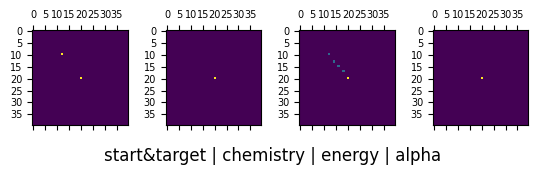

In [11]:
fig = plot_sample(x[0],[10, 12], [20, 20])

In [12]:
for t in range(50):
    x = pre_update(x)
    x = ca(x)
    x = post_update(x)

    x_n = x.numpy()
    create_frame(t,x_n[0],[10, 12],[18, 18],name="Static_Positioning",path="Static_Positioning/Static_Positioning-1")

In [13]:
frames = []
for t in range(50):
    image = imageio.v2.imread(f'../Visualization/Static_Positioning/Static_Positioning-1/img_Static_Positioning_{t}.png')
    frames.append(image)

In [14]:
imageio.mimsave('../Visualization/run1/run1.gif', # output gif
                frames,          # array of input frames
                duration=20)         # optional: frames per second

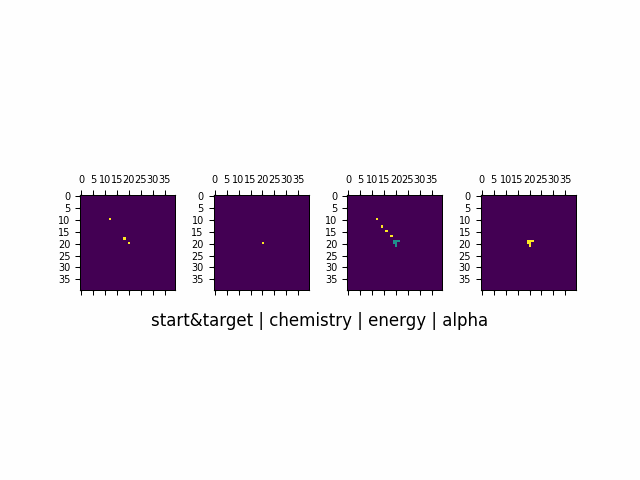

In [15]:
Image(filename='../Visualization/run1/run1.gif')